In this notebook, we address the problem of segment nuclei information from noisy background of nuclei images. <br>
The dataset can be download from https://www.kaggle.com/competitions/data-science-bowl-2018/data 

# **Unzip the dataset**

In [ ]:
from zipfile import ZipFile
cont = 0
file_name = '/content/stage1_train.zip'.format(cont)
with ZipFile(file_name, 'r') as zip: 
  zip.extractall('stage1_train')

In [ ]:
## Importaciones
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

## Seeding (así se obtienen resultados reproducibles)
seed = 2020
random.seed = seed
np.random.seed = seed
tf.seed = seed

# **Data generator**

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size, image_size, shuffle):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Ruta de la base de datos
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Imagen de entrada
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size)) #(128, 128, 3) 
        
        mask = np.zeros((self.image_size, self.image_size, 1)) #(128, 128, 1)
        
        ## Máscaras de entrada
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1) 
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128 - (128, 128)
            _mask_image = np.expand_dims(_mask_image, axis=-1) # (128, 128, 1) 
            mask = np.maximum(mask, _mask_image)
            
        ## Normalización
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        ids_arr = np.asarray(self.ids)
        files_batch = ids_arr[indexes]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image) #(8, 128, 128, 3)
        mask  = np.array(mask) #(8, 128, 128, 1)
        
        return image, mask
    
    def on_epoch_end(self):
      self.indexes = np.arange(len(self.ids))
      if self.shuffle == True:
        np.random.shuffle(self.indexes)
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

# **Hyperparameters**

In [ ]:
image_size = 128
train_path = "stage1_train/"
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Tamaño del conjunto de validación
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [ ]:
len(train_ids)

660

In [ ]:
valid_ids

['8b12e18670e4b24d03567d1e17c0c24fadf0ea2c1e763983dd6bb4c44b7376a6',
 '40bcdad218ac5f0885fc247d88fcad9f729f55c81c79d241a8f1559b6d8c0574',
 'cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e',
 'bc115ff727e997a88f7cfe4ce817745731a6c753cb9fab6a36e7e66b415a1d3d',
 'df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2',
 'e5a6c5e01e6a4ef676a2d975374e995dd55792ea317a8e110bebc37da83a4ce8',
 '4327d27591871e9c8d317071a390d1b3dcedad05a9746175b005c41ea0d797b2',
 '139946af9e2c7ef4f0298e622b831dbef5e5c0cd088eb5bc3382f8df9355443d',
 'ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48',
 '876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25']

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size, shuffle=True)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


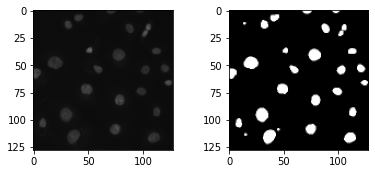

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

# **Different Convolutional Blocks**

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# **UNet model**

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

# **Compilation of the model**

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# **Training the model**

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size, shuffle=True)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size, shuffle=False)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

mc = ModelCheckpoint('/content/segmentation_model1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=[mc])

Epoch 1/5
83/83 [==============================] - 60s 332ms/step - loss: 0.4613 - acc: 0.8472 - val_loss: 0.3138 - val_acc: 0.8332

Epoch 00001: val_acc improved from -inf to 0.83318, saving model to /content/segmentation_model1.h5
Epoch 2/5
83/83 [==============================] - 27s 319ms/step - loss: 0.2086 - acc: 0.8760 - val_loss: 0.1592 - val_acc: 0.9225

Epoch 00002: val_acc improved from 0.83318 to 0.92247, saving model to /content/segmentation_model1.h5
Epoch 3/5
83/83 [==============================] - 25s 303ms/step - loss: 0.1221 - acc: 0.9364 - val_loss: 0.1094 - val_acc: 0.9417

Epoch 00003: val_acc improved from 0.92247 to 0.94171, saving model to /content/segmentation_model1.h5
Epoch 4/5
83/83 [==============================] - 27s 329ms/step - loss: 0.1040 - acc: 0.9437 - val_loss: 0.0828 - val_acc: 0.9525

Epoch 00004: val_acc improved from 0.94171 to 0.95247, saving model to /content/segmentation_model1.h5
Epoch 5/5
83/83 [==============================] - 26s 305m

# **Testing the model**

In [ ]:
# Load the model
model = keras.models.load_model('/content/segmentation_model1.h5', compile=False)

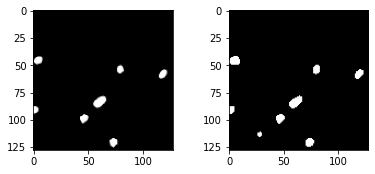

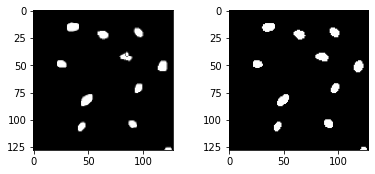

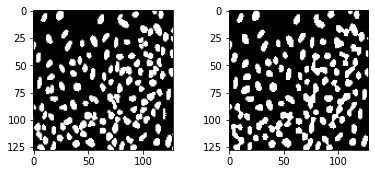

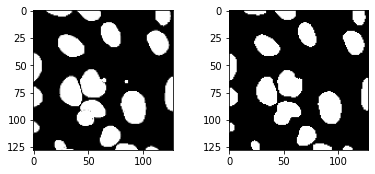

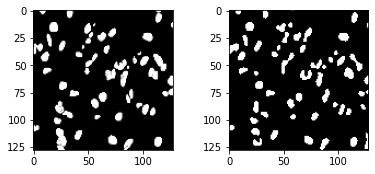

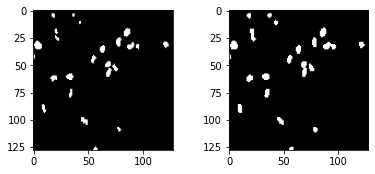

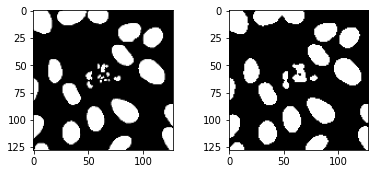

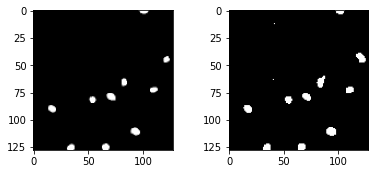

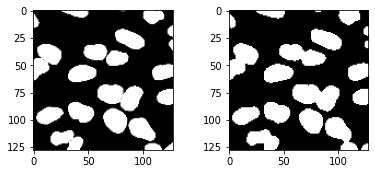

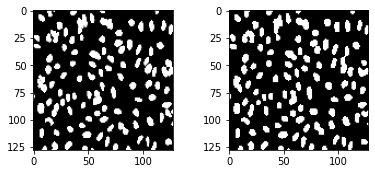

In [ ]:
## Dataset for prediction
for i in range(valid_steps+1):
  x, y = valid_gen.__getitem__(i)

  for j in range(len(x)):
    result = model.predict(x)

    result = result > 0.5

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.reshape(result[j]*255, (image_size, image_size)), cmap="gray")